# Last.fm Dataset

## Data Analysis based on the retrivied data. 

Based on the Last.fm API and with help of the pylast package, I got information about user, artists, tracks and tags. The code to generate the users and to get the data from the website are in ```scripts```. The data used here is generated in the Notebook ```last_api.ipynb```. In these scripts and notebook I used the the pyLast library, because it was built to connect with the Last.fm API. 

To generate a list of usernames, I visited the Last.fm webpage of several artists. But I considered three users randomly iin the top listenings from three different coutries: Brazil, USA and United Kingdom. Using just this username, I generated additional Last.fm usernames using the user.getFriends method. With some loops, we can get the network (or part of it). It's possible to have some bias unknown yet.  

In [1]:
import pandas as pd 
import numpy as np 
import pylast

import os 
import json 

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

from datetime import datetime

Defining paths and retriving the files with unique items. 

In [41]:
FOLDER_PATH = '../data/lastfm-api/'

user_info_path = FOLDER_PATH + '1k_users_info_lastfm.json'
track_info_path = FOLDER_PATH + 'tracks_lastfm_info.json'
artist_info_path = FOLDER_PATH + 'artists_lastfm_info.json'
tag_info_path = FOLDER_PATH + 'tags_lastfm_info.json'

def get_random_users(filepath: str, quantity: int = 1000, random_state: int = 200) -> pd.DataFrame:
    
    users = pd.read_csv(filepath, index_col='user_id')
    chosen_users = users.sample(n = quantity, replace = False, random_state = random_state, axis = 'index')
    chosen_users.index = list(range(0,len(chosen_users)))

    return chosen_users

users_df = pd.read_csv(FOLDER_PATH + 'users_lastfm.csv', index_col='user_id')
track_df = pd.read_csv(FOLDER_PATH + 'tracks.csv', sep = '\t', index_col='track_id')
artist_df = pd.read_csv(FOLDER_PATH + 'artists.csv', sep = '\t', index_col='artist_id')
tag_df = pd.read_csv(FOLDER_PATH + 'tags.csv', sep = '\t', index_col='tag_id')

Getting the data: The Last FM takes one song per time and it takes roughly 10s to retrive all information I wanted. Fot the tags and artists it requires less time. So, I got only a subset of each object considered. 

In [42]:
with open(user_info_path, 'r') as f:
    users_info = json.load(f)
with open(track_info_path, 'r') as f: 
    tracks_info = json.load(f)
with open(artist_info_path, 'r') as f:
    artists_info = json.load(f)
with open(tag_info_path, 'r') as f: 
    tags_info = json.load(f)    

for key, value in {'users': users_info, 'tracks': tracks_info, 'artists': artists_info, 'tags': tags_info}.items(): 
    print("Number of {}: {}".format(key, len(value)))
    print("Number of {} with no information: {}".format(key, len({key for key in value.keys() if len(value[key]) == 0})))

Number of users: 1000
Number of users with no information: 1
Number of tracks: 9902
Number of tracks with no information: 311
Number of artists: 1055
Number of artists with no information: 0
Number of tags: 1843
Number of tags with no information: 4


Separating the information in dictionaries and lists

In [63]:
info = []

for key in users_info.keys():
    if len(users_info[key]) == 0:
        info.append([])
        continue
    c = users_info[key]['country'] 
    a = users_info[key]['age']
    s = users_info[key]['subscriber']
    r = users_info[key]['registered_since']
    r = datetime.utcfromtimestamp(int(r))
    g = users_info[key]['gender']
    p = users_info[key]['playlists']
    pl = users_info[key]['playcount']

    info.append([int(key), c, a, s, r, g, p, pl])

info_df = pd.DataFrame(info, columns = ['user_id','country', 'age', 'subscriber', 'registered_since', 'gender', 'playlists', 'playcount'])

users_complete_df = users_df.merge(info_df, on = 'user_id')
users_complete_df.playcount = users_complete_df.playcount.astype(int)

I observe all the users considered don't insert age information neither gender. Create playlists in Last.fm is not a common thing too! I get the unique values in the three columns

In [64]:
print(users_complete_df['playlists'].unique())
print(users_complete_df['gender'].unique())
print(users_complete_df['age'].unique())

['0']
['n']
[0.]


How many subscribers? 

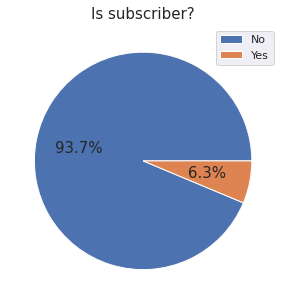

In [51]:
fig, ax = plt.subplots(figsize = (9,5))
ax.pie(users_complete_df['subscriber'].value_counts(), labels = ['No', 'Yes'], labeldistance = None,
       autopct='%1.1f%%', textprops = {'fontsize': 15})
ax.set_title('Is subscriber?', fontsize = 15)
ax.legend()
plt.show()

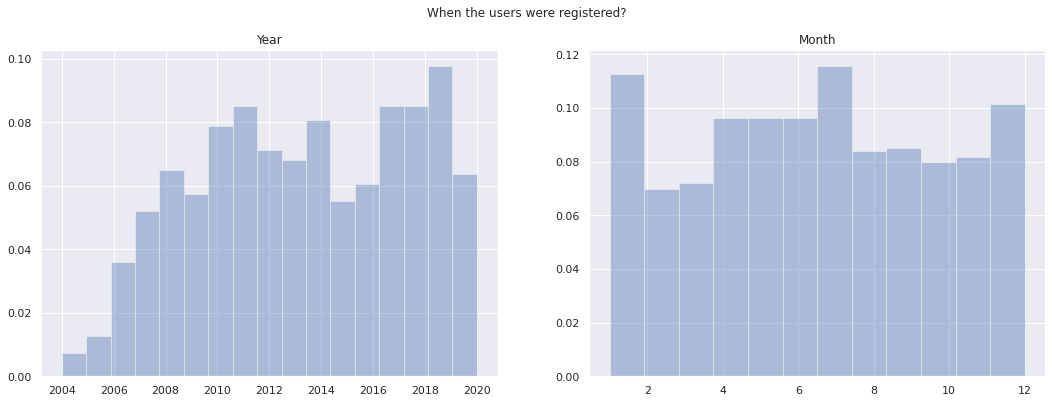

In [53]:
years = [date.year for date in users_complete_df.registered_since]
months = [date.month for date in users_complete_df.registered_since]
fig, ax = plt.subplots(1,2, figsize = (18, 6))
sns.distplot(years, kde = False, bins = max(years) - min(years) + 1, norm_hist = True, ax = ax[0])
ax[0].set_title('Year')
sns.distplot(months, kde = False, bins = 12, norm_hist = True, ax = ax[1])
ax[1].set_title('Month')
fig.suptitle('When the users were registered?')
plt.show()

In the following graphics: for each x, f(x) if the quantity that x people have obtained (at least)!

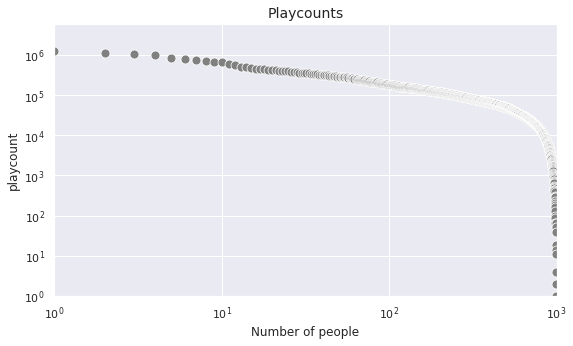

In [67]:
fig, ax = plt.subplots(figsize = (9,5))
ax.set(xscale = 'log', yscale = 'log', xlim = (1,1000), ylim = (1, 6000000))
sns.scatterplot(x = range(1, len(users_complete_df)+1), 
                y = users_complete_df.playcount.sort_values(ascending = False), s = 80, color = 'grey')
ax.set_title('Playcounts', fontsize = 14)
ax.set_xlabel('Number of people')
plt.show()

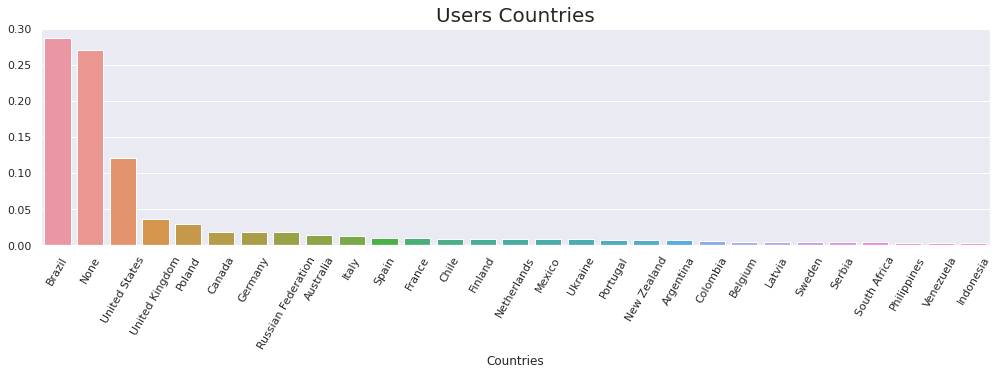

In [86]:
fig, ax = plt.subplots(figsize = (17,4))
countries_df = users_complete_df.country.value_counts(True)[users_complete_df.country.value_counts().values > 2] 
sns.barplot(x = countries_df.index, 
            y = countries_df.values, 
            ax = ax)
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 60)
ax.set_title('Users Countries', fontsize = 20)
ax.set_xlabel('Countries')
plt.show()

I separate the data from loved tracks for each user and I consider top tracks, artists anf tags. The last three have an associated weight (counts of auditions of the object by the user)

In [88]:
loved_tracks = []
top_tracks = []
top_artists = []
top_tags = []
for user_id in users_info.keys():
    if len(users_info[user_id]) == 0:
        continue
    loved_tracks.extend(users_info[user_id]['loved_tracks'])
    top_tracks.extend(users_info[user_id]['top_tracks'])
    top_artists.extend(users_info[user_id]['top_artists'])
    top_tags.extend(users_info[user_id]['top_tags'])

loved_tracks_count = {}
for loved in loved_tracks:
    if loved in loved_tracks_count:
        loved_tracks_count[loved] += 1
    else: loved_tracks_count[loved] = 1

top_tracks_count = {}
for top in top_tracks:
    if top[0] in top_tracks_count:
        top_tracks_count[top[0]] += 1
    else: top_tracks_count[top[0]] = 1

top_artists_count = {}
for top in top_artists:
    if top[0] in top_artists_count:
        top_artists_count[top[0]] += 1
    else: top_artists_count[top[0]] = 1

top_tags_count_weight = {}
for top in top_tags:
    if top[0] in top_tags_count_weight:
        top_tags_count_weight[top[0]] += int(top[1])
    else: top_tags_count_weight[top[0]] = int(top[1])

top_tags_count = {}
for top in top_tags:
    if top[0] in top_tags_count:
        top_tags_count[top[0]] += 1
    else: top_tags_count[top[0]] = 1

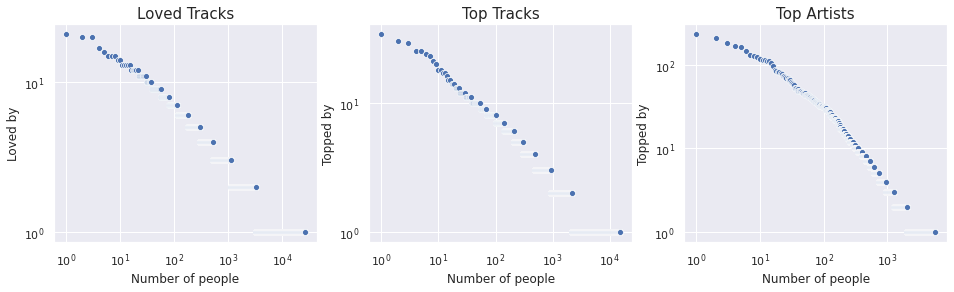

In [89]:
fig, ax = plt.subplots(1,3,figsize = (16,4))
sns.scatterplot(x = range(1,len(loved_tracks_count)+1), 
                y = sorted(loved_tracks_count.values(), reverse = True),
                ax = ax[0])
sns.scatterplot(x = range(1,len(top_tracks_count)+1), 
                y = sorted(top_tracks_count.values(), reverse = True),
                ax = ax[1])
sns.scatterplot(x = range(1,len(top_artists_count)+1), 
                y = sorted(top_artists_count.values(), reverse = True),
                ax = ax[2])
ax[0].set(xscale = 'log', yscale = 'log')
ax[0].set_title('Loved Tracks', fontsize = 15)
ax[0].set_ylabel('Loved by')
ax[0].set_xlabel('Number of people')

ax[1].set(xscale = 'log', yscale = 'log')
ax[1].set_title('Top Tracks', fontsize = 15)
ax[1].set_ylabel('Topped by')
ax[1].set_xlabel('Number of people')

ax[2].set(xscale = 'log', yscale = 'log')
ax[2].set_title('Top Artists', fontsize = 15)
ax[2].set_ylabel('Topped by')
ax[2].set_xlabel('Number of people')

plt.show()

In [90]:
fig, ax = plt.subplots(1,3,figsize = (18,6))
sns.distplot(list(top_tags_count_weight.values()),
             bins = [1, 10, 100, 1000, 10000, 100000],
             kde = False, 
             norm_hist= False,
             ax = ax[0], 
             )
total = len(top_tags_count_weight.values())
ax[0].set(xscale = 'log', yscale = 'log')
ax[0].set_title('Histogram  (with weight)', fontsize = 15)
ax[0].set_ylabel('Proportion of tags')
ax[0].set_yticklabels([np.round(10**x/total, 3) for x in (-1,0,1,2,3)])
ax[0].set_xlabel('Weight of tags')

percentages = np.flip(sorted(top_tags_count_weight.values()))/sum(top_tags_count_weight.values())
percentages = pd.DataFrame({10**b: sum(percentages[10**b - 1:10**(b+1) - 1]) for b in (0, 1, 2, 3)}, 
                        index = ['Percentage'])

sns.barplot(data = percentages, ax = ax[1])
ax[1].set_title('Distribuition Sorted by Weight', fontsize = 15)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Position of tags')
ax[1].set_xticklabels(['1-9', '10 - 99', '100 - 999', '+ 1000'])

sns.distplot(list(top_tags_count.values()),
             bins = [1, 3, 9, 27, 81, 243],
             kde = False, 
             norm_hist= False,
             ax = ax[2], 
             )
total = len(top_tags_count_weight.values())
ax[2].set(xscale = 'log', yscale = 'log')
ax[2].set_title('Histogram (no weight)', fontsize = 15)
ax[2].set_ylabel('Proportion of tags')
ax[2].set_yticklabels([np.round(10**x/total, 3) for x in (-2,-1,0,1,2,3)])
ax[2].set_xlabel('Count of tags')

fig.suptitle('Top Tags', fontsize = 18)
plt.show()

In [112]:
top_tags_count_weight_df = pd.DataFrame({'tag_id': list(top_tags_count_weight.keys()), 
                                         'weight_user': list(top_tags_count_weight.values())}
                                        )
tags = pd.read_csv('../data/lastfm-api/tags.csv', sep = '\t', index_col='tag_id')
tags = tags.merge(top_tags_count_weight_df, on = 'tag_id')
tags.sort_values(by = 'weight_user', ascending = False).head(10)

tag_id             tag  weight_user
187     188             All        52112
217     218         spotify        45867
647     648        katarakt         4351
552     553      essentials         2836
648     649  scare the kids         2138
94       95    albums I own         1960
48       49             pop         1892
47       48           noise         1544
450     451     heavy metal         1502
649     650         ponyhof         1472

## Tag Dataset

In [96]:
reached = {int(key): tags_info[key]['reached'] for key in tags_info.keys() if len(tags_info[key]) > 0}
tagging = {int(key): tags_info[key]['taggings'] for key in tags_info.keys() if len(tags_info[key]) > 0}
tags_reached = pd.DataFrame({'tag_id': list(reached.keys()), 'tag_reached': list(reached.values()), 'taggings': list(tagging.values())})
tags_complete_df = tag_df.merge(tags_reached, on = 'tag_id')
tags_complete_df.sort_values(by = 'taggings', ascending = False, inplace = True)
tags_complete_df.head(10)

tag_id               tag  tag_reached  taggings
49       50              rock       395583   3979593
67       68        electronic       254123   2371259
73       74         seen live        81737   2142301
50       51       alternative       261864   2095454
39       40             indie       253561   2017410
48       49               pop       225821   1974141
59       60  female vocalists       167842   1599333
166     167             metal       155620   1259398
64       65  alternative rock       166856   1166430
192     193              jazz       146565   1150644

In [116]:
info = []

for key in artists_info.keys():
    if len(artists_info[key]) == 0:
        info.append([])
        continue
    l = artists_info[key]['listeners'] 
    p = artists_info[key]['plays']
    pu = artists_info[key]['published']

    info.append([int(key), l, p, pu])

info_df = pd.DataFrame(info, columns = ['artist_id','listeners', 'plays', 'published'])

artists_complete_df = artist_df.merge(info_df, on = 'artist_id')
artists_complete_df.sort_values(by = 'listeners', ascending = False).head(10)

artists_complete_df['year'] = artists_complete_df['published'].apply(lambda x: int(x[0:4]) if x else None)

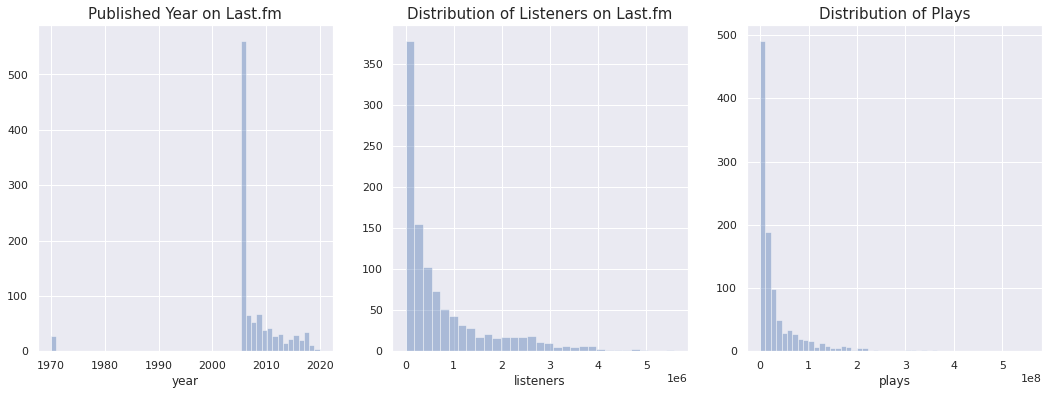

In [126]:
fig, ax = plt.subplots(1,3, figsize = (18, 6))
sns.distplot(artists_complete_df.year, kde = False, 
            bins = int(artists_complete_df.year.max() - artists_complete_df.year.min()) + 1,
            ax = ax[0])
ax[0].set_title('Published Year on Last.fm', fontsize = 15)
sns.distplot(artists_complete_df.listeners, kde = False, 
            #bins = int(artists_complete_df.year.max() - artists_complete_df.year.min()) + 1,
            ax = ax[1])
ax[1].set_title('Distribution of Listeners on Last.fm', fontsize = 15)
sns.distplot(artists_complete_df.plays, kde = False, 
            #bins = int(artists_complete_df.year.max() - artists_complete_df.year.min()) + 1,
            ax = ax[2])
ax[2].set_title('Distribution of Plays', fontsize = 15)
plt.show()